## Data Processing and Visualization Workflow to train the Upscalling Neural Network

This notebook demonstrates a comprehensive approach to processing and visualizing satellite and model data. The workflow includes the following steps:

### 1. SWOT Data Handling
- **Upload and Plot**: Import Level 3 SWOT satellite data and generate plots.
- **Path Selection**: Focus on a specific segment of the SWOT path.

### 2. Integration with Altimetry and GLORYS model Data
- **AVISO Altimetry**: Extract and analyze AVISO altimetry data corresponding to the area of the selected SWOT path.
- **GLORYS Model Data**: Access and process GLORYS model data for the same region.

### 3. Data Processing
- **Smoothing and Interpolation**: Smooth and interpolate the GLORYS data to align with the AVISO grid.
- **Regridding**: Regrid the original GLORYS output to ensure consistency across datasets.

### 4. Visualization
- **Regridded GLORYS Output**: Plot the regridded GLORYS model output.
- **Smoothed GLORYS Data**: Create visualizations of the smoothed GLORYS data for comparative analysis.

These steps prepare the data for effective machine learning analysis, enabling a detailed investigation of relationships and patterns within the datasets.

### Import Necessary Libraries

In [2]:
# Library for handling multi-dimensional labeled arrays, especially useful for working with NetCDF files
import xarray as xr

# Library for accessing data from the Copernicus Marine Environment Monitoring Service (CMEMS)
import copernicusmarine 

# Library for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt  

# Submodule for specifying complex subplot grids in matplotlib figures
from matplotlib.gridspec import GridSpec 

# Fundamental package for scientific computing with Python, providing support for arrays and numerical operations
import numpy as np 

# Import the Cartopy library's coordinate reference system (CRS) module for handling map projections and geospatial data
import cartopy.crs as ccrs

### **SWOT Data Processing and Visualization**

This section deals with loading and processing the SWOT data.


In [3]:
# Load SWOT data from multiple NetCDF files in a directory
swot = xr.open_mfdataset(
    '/home/jovyan/shared/cycle_500/*.nc',  # Path pattern to the NetCDF files to be opened
    combine='nested',                      # Combine the datasets using a nested approach
    concat_dim='num_lines',                # Dimension along which to concatenate the datasets
    parallel=True,                         # Enable parallel processing for faster file reading
    preprocess=lambda ds: ds.drop_vars(['i_num_line', 'i_num_pixel'], errors='ignore')  # Drop unnecessary variables from the datasets, ignoring any errors if the variables are not present
)
# Sort SWOT data by time
swot = swot.sortby('time')

In [4]:
swot

<xarray.Dataset> Size: 764MB
Dimensions:         (num_lines: 276080, num_pixels: 69)
Coordinates:
    latitude        (num_lines, num_pixels) float64 152MB dask.array<chunksize=(9860, 69), meta=np.ndarray>
    longitude       (num_lines, num_pixels) float64 152MB dask.array<chunksize=(9860, 69), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time            (num_lines) datetime64[ns] 2MB dask.array<chunksize=(9860,), meta=np.ndarray>
    mdt             (num_lines, num_pixels) float64 152MB dask.array<chunksize=(9860, 69), meta=np.ndarray>
    ssha            (num_lines, num_pixels) float64 152MB dask.array<chunksize=(9860, 69), meta=np.ndarray>
    ssha_noiseless  (num_lines, num_pixels) float64 152MB dask.array<chunksize=(9860, 69), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              8.4e-05
    geospatial_lon_max:              359.999504
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...

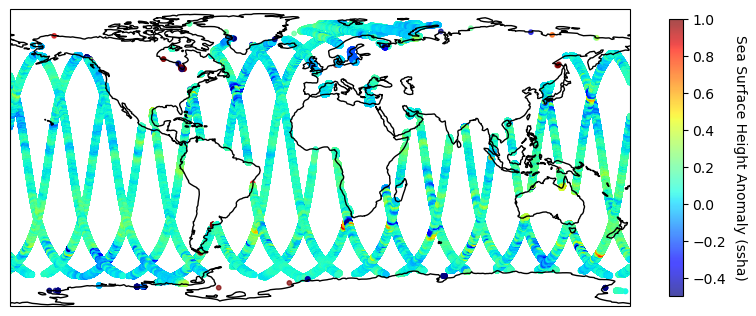

In [22]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

scatter = plt.scatter(
    x=swot.longitude,         # Extract longitude values
    y=swot.latitude,          # Extract latitude values
    c=swot.ssha,              # Color by sea surface height anomaly (ssha)
    cmap='jet',               # Apply the colormap
    s=10,                     # Set the marker size
    alpha=0.7,                # Set marker transparency
    marker='o',               # Use circular markers
    vmin = -.5,               # minimum colormap color
    vmax = 1                  # maximum colormap color
)

# Add a color bar with label
cbar = plt.colorbar(scatter,shrink=.6)
cbar.set_label('Sea Surface Height Anomaly (ssha)', rotation=270, labelpad=15)  # Label for color bar

plt.savefig('swot_path.png',dpi=300,bbox_inches='tight')

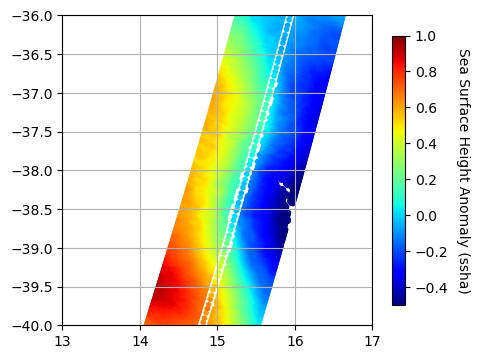

In [23]:
longitude_values = swot.longitude[:12000].values
latitude_values = swot.latitude[:12000].values
ssha_values = swot.ssha[:12000].values

# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5,5))
scatter = plt.scatter(
    x=longitude_values,  # Extract longitude values
    y=latitude_values,   # Extract latitude values
    c=ssha_values,       # Color by sea surface height anomaly (ssha)
    marker='.',          # Use point markers
    cmap='jet',       # Apply the colormap (you can adjust this as needed)
    vmin = -.5,               # minimum colormap color
    vmax = 1                  # maximum colormap color
)

# Add a color bar with label
cbar = plt.colorbar(scatter,shrink=.7)
cbar.set_label('Sea Surface Height Anomaly (ssha)', rotation=270, labelpad=15)  # Label for color bar

# Set plot limits
plt.xlim(13, 17)   # Set the x-axis limits
plt.ylim(-40, -36) # Set the y-axis limits
ax.set_aspect('equal')  

plt.grid(True)  # Add grid for better readability

plt.savefig('swot_path_zoom.png',dpi=300,bbox_inches='tight')

### **AVISO Altimetry Data Processing and Visualization**

This section deals with loading and processing the AVISO Altimetry data.


In [5]:
def copernicus(ID, lon, lat, time, var, username='pwalfir', password='PedroW100%'):
    """
    Fetches data from the Copernicus Marine Environment Monitoring Service based on the provided parameters.

    Parameters:
    - ID (str): Dataset identifier for the Copernicus dataset to be accessed.
    - lon (list or tuple): List or tuple containing the minimum and maximum longitude for the area of interest.
    - lat (list or tuple): List or tuple containing the minimum and maximum latitude for the area of interest.
    - time (list or tuple): List or tuple containing the start and end datetime for the data retrieval period.
    - var (list of str): List of variable names to be retrieved from the dataset.
    - username (str, optional): Username for authentication. Default is 'pwalfir'.
    - password (str, optional): Password for authentication. Default is 'PedroW100%' (change this to your own credentials).

    Returns:
    - dat (xarray.Dataset): An xarray Dataset object containing the requested data.
    """
    
    # Set up the data request parameters
    data_request = {
       "dataset" : ID,          # Dataset identifier
       "longitude" : lon,       # Longitude range for data extraction
       "latitude" : lat,        # Latitude range for data extraction
       "time" : time,           # Time range for data extraction
       "variables" : var        # List of variables to retrieve
    }

    # Load the dataset from Copernicus Marine using specified parameters
    dat = copernicusmarine.open_dataset(
        dataset_id = data_request["dataset"],                 # Dataset ID
        minimum_longitude = data_request["longitude"][0],     # Minimum longitude
        maximum_longitude = data_request["longitude"][1],     # Maximum longitude
        minimum_latitude = data_request["latitude"][0],       # Minimum latitude
        maximum_latitude = data_request["latitude"][1],       # Maximum latitude
        start_datetime = data_request["time"][0],             # Start datetime
        end_datetime = data_request["time"][1],               # End datetime
        variables = data_request["variables"],                # Variables to include
        username  = username,                               # Username for authentication
        password = password                                # Password for authentication
    )
    
    return dat


In [6]:
dat_aviso = copernicus("cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D",
                       [13,17],
                       [-40, -36],
                       ["1993-01-01", "2021-06-30"],
                       ["adt"])

INFO - 2024-08-30T17:22:34Z - Dataset version was not specified, the latest one was selected: "202112"
INFO - 2024-08-30T17:22:34Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-30T17:22:37Z - Service was not specified, the default one was selected: "arco-time-series"


In [7]:
dat_aviso

<xarray.Dataset> Size: 21MB
Dimensions:    (time: 10408, latitude: 16, longitude: 16)
Coordinates:
  * latitude   (latitude) float32 64B -39.88 -39.62 -39.38 ... -36.38 -36.12
  * longitude  (longitude) float32 64B 13.12 13.38 13.62 ... 16.38 16.62 16.88
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    adt        (time, latitude, longitude) float64 21MB ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

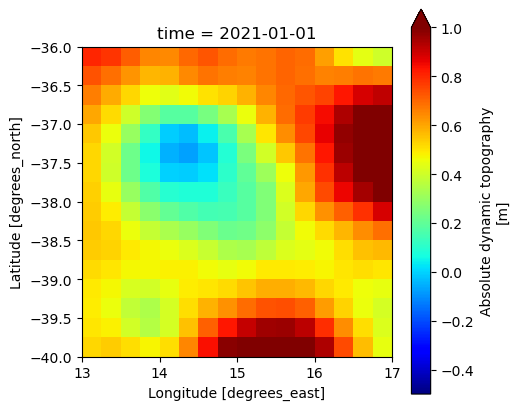

In [8]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot = dat_aviso.adt.sel(time="2021-01-01").plot(
    cmap='jet',               
    vmin=-.5,                  
    vmax=1)

ax.set_aspect('equal')  

### **GLORYS12V1 Output Processing and Visualization**

This section deals with loading and processing the GLORYS12V1 model output.


In [9]:
dat_glorys = copernicus("cmems_mod_glo_phy_my_0.083deg_P1D-m",
                        [12,18],
                        [-41, -35],
                        ["1993-01-01", "2021-06-30"],
                        ["zos"])


INFO - 2024-08-30T17:22:46Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-30T17:22:46Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-30T17:22:48Z - Service was not specified, the default one was selected: "arco-time-series"


In [10]:
dat_glorys

<xarray.Dataset> Size: 222MB
Dimensions:    (time: 10408, latitude: 73, longitude: 73)
Coordinates:
  * latitude   (latitude) float32 292B -41.0 -40.92 -40.83 ... -35.08 -35.0
  * longitude  (longitude) float32 292B 12.0 12.08 12.17 ... 17.83 17.92 18.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    zos        (time, latitude, longitude) float32 222MB ...
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

#### Apply a rolling mean to the GLORYS dataset to smooth data
#### Compute the mean within each window to smooth the data

In [25]:
dat_dow = dat_glorys.rolling(latitude=3,longitude=3,center=True).mean()

#### Interpolate the smoothed GLORYS dataset to match the grid and coordinates of the AVISO dataset

In [26]:
dat_dow = dat_dow.interp_like(dat_aviso)

#### Define new latitude and longitude arrays with a resolution of 1/12 degree

In [19]:
lati = np.arange(dat_aviso.latitude.min(),dat_aviso.latitude.max()-.001+(1/12),1/12)
loni = np.arange(dat_aviso.longitude.min(),dat_aviso.longitude.max()+(1/12),1/12)

In [21]:
loni

array([13.125     , 13.20833333, 13.29166667, 13.375     , 13.45833333,
       13.54166667, 13.625     , 13.70833333, 13.79166667, 13.875     ,
       13.95833333, 14.04166667, 14.125     , 14.20833333, 14.29166667,
       14.375     , 14.45833333, 14.54166667, 14.625     , 14.70833333,
       14.79166667, 14.875     , 14.95833333, 15.04166667, 15.125     ,
       15.20833333, 15.29166667, 15.375     , 15.45833333, 15.54166667,
       15.625     , 15.70833333, 15.79166667, 15.875     , 15.95833333,
       16.04166667, 16.125     , 16.20833333, 16.29166667, 16.375     ,
       16.45833333, 16.54166667, 16.625     , 16.70833333, 16.79166667,
       16.875     ])

#### Interpolate the GLORYS dataset to the new latitude and longitude grid

In [12]:
dat_glorys_i = dat_glorys.interp(latitude=lati,longitude=loni)

In [13]:
dat_glorys_i

<xarray.Dataset> Size: 176MB
Dimensions:    (time: 10408, latitude: 46, longitude: 46)
Coordinates:
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * latitude   (latitude) float64 368B -39.88 -39.79 -39.71 ... -36.21 -36.12
  * longitude  (longitude) float64 368B 13.12 13.21 13.29 ... 16.71 16.79 16.88
Data variables:
    zos        (time, latitude, longitude) float64 176MB -0.1646 ... -0.07859
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

In [29]:
dat_dow

<xarray.Dataset> Size: 21MB
Dimensions:    (time: 10408, latitude: 16, longitude: 16)
Coordinates:
  * latitude   (latitude) float32 64B -39.88 -39.62 -39.38 ... -36.38 -36.12
  * longitude  (longitude) float32 64B 13.12 13.38 13.62 ... 16.38 16.62 16.88
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    zos        (time, latitude, longitude) float64 21MB -0.1661 ... -0.07552
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

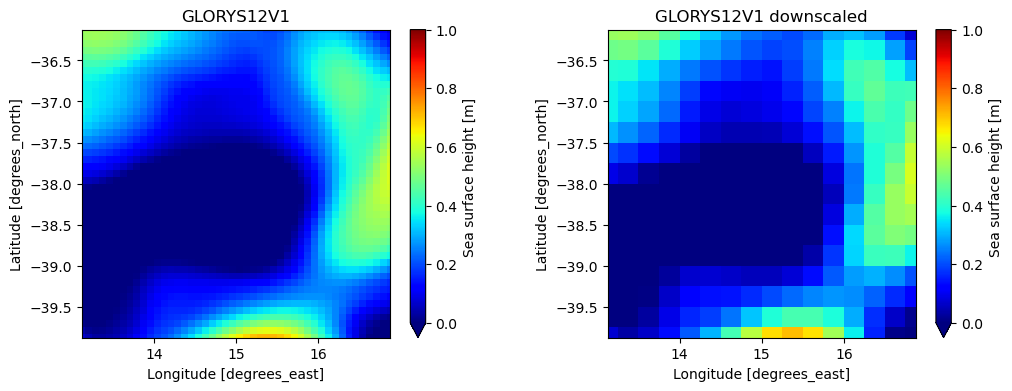

In [29]:
fig = plt.figure(figsize=(12,4))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.3)  # Define a 1x2 grid with space between subplots

ax1 = fig.add_subplot(gs[0])
c1 = dat_glorys_i.zos.sel(time="2021-01-01").plot(vmin=0,vmax=1, cmap='jet')
ax1.set_aspect('equal') 
plt.xlim(dat_aviso.longitude.min(),dat_aviso.longitude.max())
plt.ylim(dat_aviso.latitude.min(),dat_aviso.latitude.max())
ax1.set_title('GLORYS12V1')

ax2 = fig.add_subplot(gs[1]) 
c2 = dat_dow.zos.sel(time="2021-01-01").plot(vmin=0,vmax=1, cmap='jet')
ax2.set_aspect('equal')  
plt.xlim(dat_aviso.longitude.min(),dat_aviso.longitude.max())
plt.ylim(dat_aviso.latitude.min(),dat_aviso.latitude.max())
ax2.set_title('GLORYS12V1 downscaled')

plt.savefig('glorys.png',dpi=300,bbox_inches='tight')
